# scipy-stats

## Overview

The SciPy Python library is a large collection of scientific computing algorithms and functions presented in a number of subpackages in the domain of, among others, integration, interpolation, optimisation, linear algebra, image and signal processing, and statistics [1]. The library is based on numpy [2]. The SciPy-stats package [3] 

In [2]:
# imports
from scipy import stats as ss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

The Palmer Penguins dataset is considered a good alternative to Fisher's Iris for exploring data analysis concepts and techniques [1]. The details of how the data has been transformed for use in the R package 'palmerpenguins' are unclear so the three datasets of which it is composed, 'adelie', 'gentoo', and 'chinstrap' have been downloaded from the source EDI data portal [2] and cleaned and subset in the first cells of this notebook. The data will be used to demonstrate the process of conducting an ANOVA test using the scipy-stats package [3].

Below the penguin data is downloaded, concatenated to a single pandas DataFrame, and written to disk as csv.

In [3]:

data_dir = 'data/penguins'
penguins_raw = os.path.join(data_dir, 'penguins_raw.csv')

# Download penguin data if the raw data does not
# already exist in the data directory
if not os.path.exists(penguins_raw):

    # Penguin data locations
    urls = {
        'adelie': 'https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.219.5&entityid=002f3893385f710df69eeebe893144ff',
        'gentoo': 'https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.220.5&entityid=e03b43c924f226486f2f0ab6709d2381',
        'chinstrap': 'https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.221.6&entityid=fe853aa8f7a59aa84cdd3197619ef462'
    }
    # Download csv files and concatenate to one dataframe
    penguins = pd.concat([pd.read_csv(url) for url in urls.values()])
    # Write dataframe to disk as csv
    csv = penguins.to_csv(index=False)

    with open(penguins_raw, 'w') as f:
        f.write(csv)

    # Backup location
    timestamp = datetime.now().strftime("_%Y%m%d_%H%M%S")
    backup_fname = 'penguins_raw' + timestamp + '.csv'
    backup = os.path.join(data_dir, 'backup', backup_fname)
    with open(backup, 'w') as f:
        f.write(csv)
    

The penguin data is subset to hold only the five attributes of interest: species, culmen length, culmen depth, flipper length, and body mass.

In [4]:
penguins_min = os.path.join(data_dir, 'penguins_min.csv')

def subset_penguins():
    # Read the raw penguin data to a DataFrame
    df = pd.read_csv(penguins_raw)
    # Drop most of the columns
    df = df[['Species', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']]
    # Drop rows with missing data
    df.dropna(inplace=True)
    # Make column names easier to type
    df.columns = df.columns.str.replace(' \(.+\)', '', regex=True)
    # Make Species names more concise
    df['Species'] = df['Species'].str.replace('\s+.+$', '', regex=True)
    # Write csv to disk
    df.to_csv(penguins_min, index=False)

    return df

if os.path.exists(penguins_min):
    penguins = pd.read_csv(penguins_min)
else:
    penguins = subset_penguins()


In [32]:
# See how many penguins in each group
penguins['Species'].value_counts()

Adelie       151
Gentoo       123
Chinstrap     68
Name: Species, dtype: int64

In [5]:
# Check out the data
penguins.head()

,Species,Culmen Length,Culmen Depth,Flipper Length,Body Mass
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,36.7,19.3,193.0,3450.0
4,Adelie,39.3,20.6,190.0,3650.0


In [44]:
# Give the penguin species' short names
adelie = penguins[penguins['Species'] == 'Adelie']['Flipper Length']
gentoo = penguins[penguins['Species'] == 'Gentoo']['Flipper Length']
chinstrap = penguins[penguins['Species'] == 'Chinstrap']['Flipper Length']

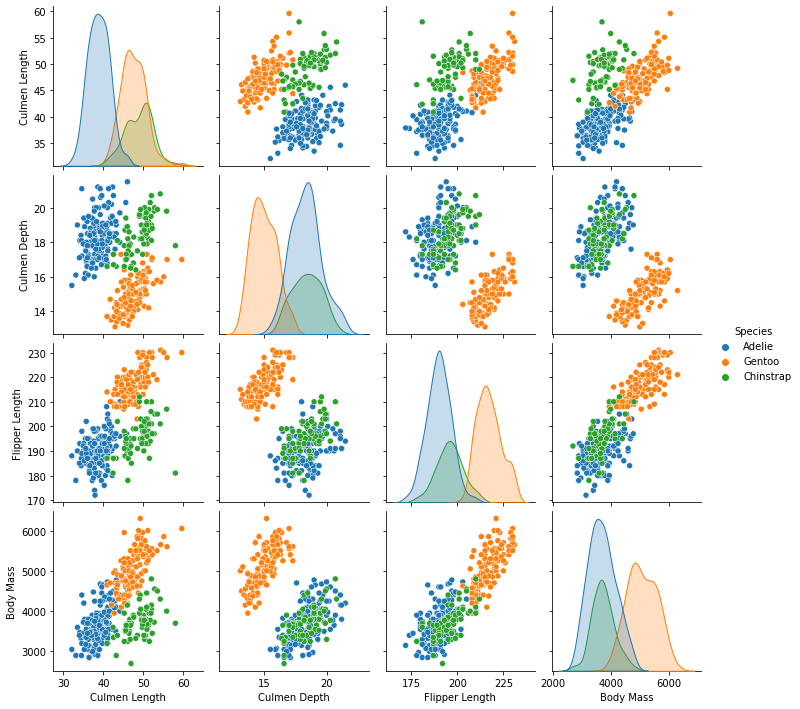

In [6]:
sns.pairplot(penguins, hue='Species');

## ANOVA

ANOVA or analysis of variance is a method for assessing whether or not two or more samples come from the same population by testing if their population means differ significantly. It is a hypothesis test in which the null hypothesis, $H_0$ is that all of the samples are draw from populations with the same mean [R]. 



### Assumptions

A number of assumptions are made of the data subjected to ANOVA for the analysis to be valid:

1. The dependent variable must be continuous.
1. The independent variable should be categorical, and should consist of two or more categories.
1. All observations should be independent of one another.
1. There should be no significant outliers.
1. The dependent variable should be normally distributed within each category of the independent variable.
1. All of the dependent variable groups should have the same variance.


It is proposed here to assess whether the Palmer penguin flipper size varies by species. This will be explored by means of an analysis of variance between the flipper sizes of the three Palmer penguin species. The null hypothesis, $H_0$ is that the flipper size of each of the three groups comes from populations with the same mean and that , consequently, flipper size is not contingent on species. If $H_0$ is rejected, then we can say that flipper size is dependent on the species of penguin to which it is attached, at least in the case of the Palmer penguins.

For the purposes of this test, the dependent variable is flipper size, and the independent variable is species.

##### Assumption 1. The dependent variable must be continuous
Viewing a few values of the dependent variable, and the fact that its dtype is float64, demonstrates that it is, indeed, continuous.

In [11]:
# View a sample of the independent variable and its dtype
penguins['Flipper Length'].head()

0    181.0
1    186.0
2    195.0
3    193.0
4    190.0
Name: Flipper Length, dtype: float64

##### Assumption 2. The independent variable should be categorical with two or more values
Calling unique() on the indpendent variable demonstrates that it is a categorical variable with three possible values; Adelie, Gentoo, and Chinstrap.

In [13]:
penguins['Species'].unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

##### Assumption 3. All observations should be independent
Each row of the Palmer penguins dataset records the attributes of a single penguin. It is assumed that no penguin has been recorded. Therefore all observations can be assumed to be independent.

##### Assumption 4. There should be no significant outliers
There is no rigorous definition of an outlier. The *Penguin Dictionary of Statistics* states, a little vaguely, that it is "an observation that seems very unusual and does not fit the general pattern of other values in a sample" [4]. The seaborn boxplot provides a quick method to visually check for *its* definition of outliers, but the documentation is not specific as to how it defines the term. In fact, it is user definable via the `whis` parameter, which determines the boxplot's whisker extent and by extension, the value of what is considered an outlier because that is what any point outside that extent is considered [5]. The default value of `whis` is, according to a *Stack Overflow* contributor, 1.5 [6], therefore, seaborn's boxplot designates any point outside 1.5 $\times$ the interquartile range (IQR). This is confirmed in the *NIST/SEMATECH e-Handbook of Statistical Methods* which, confidently statues that an outlier is a point that lies above the third quartile by more than 1.5 $\times$ IQR, or below the first quartile by the same amount [7].

So, observation of a Seaborn boxplot shows two outliers in the 'Adelie' category. 

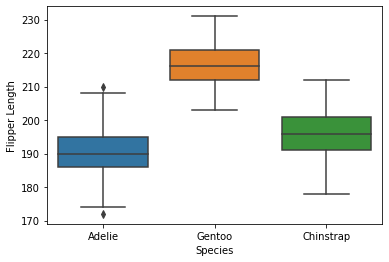

In [7]:
sns.boxplot(x='Species', y='Flipper Length', data=penguins);

We can calculate the first and third quartiles and the IQR using `scipy.stats.mstats.idealfourths()` and `scipy.stats.iqr`, respectively: 

In [45]:
# Get Adelie IQR
iqr = ss.iqr(adelie)
# Get Adelit Q1 and Q3
Qs = ss.mstats.idealfourths(adelie)
# calculate lower and upper bounds
# outside which we offically have an outlier
Qs[0] = Qs[0] - (iqr * 1.5)
Qs[1] = Qs[1] + (iqr * 1.5)
Qs

[172.5, 208.5]

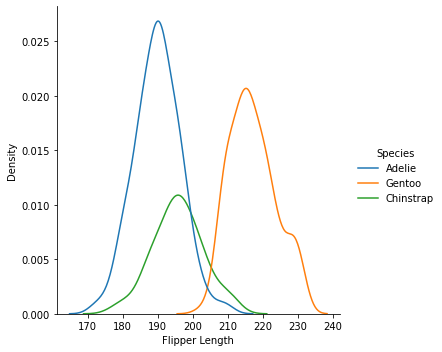

In [9]:
sns.displot(data=penguins, x='Flipper Length', hue='Species', kind='kde');

Assumptions
1. Dependent variable must be continuous
1. Independent variable must consist of 2 or more independent categorical groups
1. Observations should be independent
1. No significant outliers
1. Dependent variable approx. normally distributed for each independent category
1. homogeneity of variances


### Using ANOVA with scipy-stats

outliers---boxplot

check for normality of EACH independent category 
                    --- kde (distplot?)
                    --- shapiro-wilkes
                    
homogeneity of variances --- levene's test for homogeneity of variance
                         --- scipy.stats.levene

ANOVA: scipy.stats.f_oneway   ----- also check statsmodels

Perform post-hoc tests --- see notebook

## References

[1] Horst, A. M., Hill, A. P., Gorman, K. B., 2020, palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. [online]. Available at https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218

[2] Environmental Data Initiative, 2021, Data Repository and Curation Service [online]. Available at https://environmentaldatainitiative.org/

[3] Scipy Community, 2021, Scipy-stats reference [online]. Available at https://docs.scipy.org/doc/scipy/reference/stats.html

[4] Nelson, D., 2004, Dictionary of Statistics, Penguin: London

[5] Waskom, M., 2021, seaborn.boxplot [online]. Available at https://seaborn.pydata.org/generated/seaborn.boxplot.html

[6] Stack Overflow Contributor, 2017, Python Seaborn - How are outliers determined in boxplots? [online] Available at https://stackoverflow.com/a/46628653

[7] NIST/SEMATECH, 2012, e-Handbook of Statistical Methods [online]. Available at www.itl.nist.gov. doi:10.18434/m32189 
